In [1]:
import sys 
sys.path.append('../') # 작업디렉터리 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt 

from datetime import timedelta
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm

# model을 import
from models.model import Informer

## Util function 

In [12]:
# standard scler 구현
class StandardScaler():
    def __init__(self):
        self.mean = 0.
        self.std = 1.
    
    def fit(self, data):
        self.mean = data.mean(0)
        self.std = data.std(0)

    def transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data - mean) / std

    def inverse_transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data * std) + mean
        
# 시간 특징을 freq에 따라 추출
def time_features(dates, freq='h'):
    dates['month'] = dates.date.apply(lambda row:row.month,1)
    dates['day'] = dates.date.apply(lambda row:row.day,1)
    dates['weekday'] = dates.date.apply(lambda row:row.weekday(),1)
    dates['hour'] = dates.date.apply(lambda row:row.hour,1)
    dates['minute'] = dates.date.apply(lambda row:row.minute,1)
    dates['minute'] = dates.minute.map(lambda x:x//15)
    freq_map = {
        'y':[],'m':['month'],'w':['month'],'d':['month','day','weekday'],
        'b':['month','day','weekday'],'h':['month','day','weekday','hour'],
        't':['month','day','weekday','hour','minute'],
    }
    return dates[freq_map[freq.lower()]].values

# 한번의 batch를 실행하는 코드
def _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float()
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)
    dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
    dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float().to(device)
    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    batch_y = batch_y[:,-pred_len:,0:].to(device)
    return outputs, batch_y

## Dataset 

In [51]:
class Dataset_Pred(Dataset):
    def __init__(self, dataframe, size=None, scale=True):
        self.seq_len = size[0]
        self.label_len = size[1]
        self.pred_len = size[2]
        self.dataframe = dataframe
        
        self.scale = scale
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = self.dataframe
        df_raw["date"] = pd.to_datetime(df_raw["date"])

        delta = df_raw["date"].iloc[1] - df_raw["date"].iloc[0]
        if delta>=timedelta(hours=1):
            self.freq='h'
        else:
            self.freq='t'

        border1 = 0
        border2 = len(df_raw)
        cols_data = df_raw.columns[1:]
        df_data = df_raw[cols_data]


        if self.scale:
            self.scaler.fit(df_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values
            
        tmp_stamp = df_raw[['date']][border1:border2]
        tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)
        pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq='d')
        
        df_stamp = pd.DataFrame(columns = ['date'])
        df_stamp.date = list(tmp_stamp.date.values) + list(pred_dates[1:])
        data_stamp = time_features(df_stamp, freq=self.freq)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]
        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len- self.pred_len + 1

In [22]:
pred_len = 24

scaler = StandardScaler()
df_raw = data_tr.copy()
df_raw["date"] = pd.to_datetime(df_raw["date"])

delta = df_raw["date"].iloc[1] - df_raw["date"].iloc[0]
if delta>=timedelta(hours=1):
    freq='h'
else:
    freq='t'

border1 = 0
border2 = len(df_raw)
cols_data = df_raw.columns[1:]
df_data = df_raw[cols_data]


scaler.fit(df_data.values)
data = scaler.transform(df_data.values)

    
tmp_stamp = df_raw[['date']][border1:border2]
tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)
pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=pred_len+1, freq='d')

df_stamp = pd.DataFrame(columns = ['date'])
df_stamp.date = list(tmp_stamp.date.values) + list(pred_dates[1:])
data_stamp = time_features(df_stamp, freq=freq)

data_x = data[border1:border2]
data_y = data[border1:border2]
data_stamp = data_stamp

In [23]:
data_x.shape

(1360, 1)

In [24]:
data_y.shape

(1360, 1)

In [25]:
data_stamp.shape

(1384, 4)

In [26]:
(data_x == data_y).sum()

1360

In [27]:
data_stamp

array([[ 9, 29,  4,  0],
       [ 9, 30,  5,  0],
       [10,  1,  6,  0],
       ...,
       [ 7, 11,  6,  0],
       [ 7, 12,  0,  0],
       [ 7, 13,  1,  0]], dtype=int64)

In [30]:
index = 0
seq_len = 96
label_len = 48
pred_len = 24

s_begin = index
s_end = s_begin + seq_len
r_begin = s_end - label_len
r_end = r_begin + label_len + pred_len

seq_x = data_x[s_begin:s_end]
seq_y = data_y[r_begin:r_end]
seq_x_mark = data_stamp[s_begin:s_end]
seq_y_mark = data_stamp[r_begin:r_end]
# seq_x, seq_y, seq_x_mark, seq_y_mark

In [31]:
seq_x.shape

(96, 1)

In [32]:
seq_y.shape

(72, 1)

In [33]:
seq_x_mark.shape

(96, 4)

In [34]:
seq_y_mark.shape

(72, 4)

## Load Data

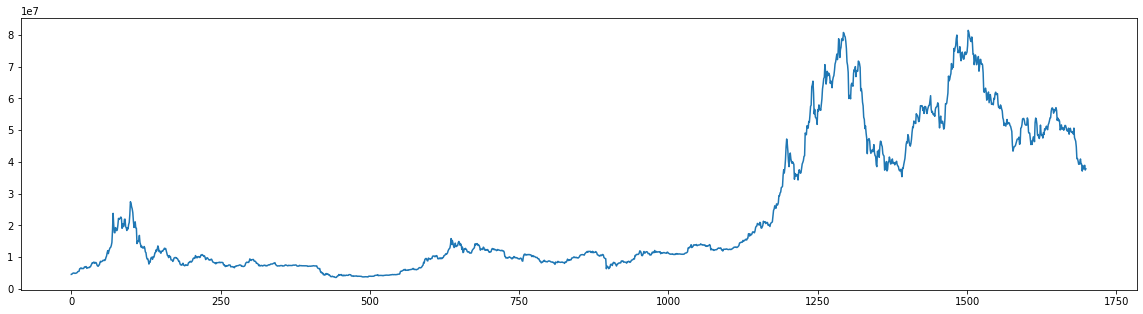

,index,open,high,low,close,volume,value
0,2017-09-29 09:00:00+09:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08
1,2017-09-30 09:00:00+09:00,4657000.0,4896000.0,4651000.0,4895000.0,19.998483,9.561476e+07
2,2017-10-01 09:00:00+09:00,4889000.0,4978000.0,4682000.0,4962000.0,27.323332,1.331325e+08
3,2017-10-02 09:00:00+09:00,4962000.0,5095000.0,4956000.0,5025000.0,31.728004,1.599315e+08
4,2017-10-03 09:00:00+09:00,5021000.0,5079000.0,4811000.0,4964000.0,11.899307,5.890130e+07


In [38]:
data = pd.read_csv('../dataset/upbit_ohlcv_1700.csv', parse_dates=['index'])
plt.figure(figsize=(20,5))
plt.plot(data["open"])
plt.show()
data.head()

In [39]:
data = data[['index', 'open']]
data.rename(columns={'index':'date'}, inplace=True)

In [40]:
pred_len = 24#예측할 크기

# train / test split
train_periods = int(data.shape[0] * 0.8)

data_tr = data.iloc[:train_periods, :]
data_te = data.iloc[train_periods:, :]

In [41]:
data_tr.shape

(1360, 2)

In [42]:
data_te.shape

(340, 2)

In [52]:
seq_len = 96#인풋 크기
label_len = 48#디코더에서 참고할 크기
pred_len = 24#예측할 크기

batch_size = 32
shuffle_flag = True
num_workers = 0
drop_last = True

dataset = Dataset_Pred(dataframe=data_tr ,scale=True, size = (seq_len, label_len,pred_len))
data_loader = DataLoader(dataset,batch_size=batch_size,shuffle=shuffle_flag,num_workers=num_workers,drop_last=drop_last)

C:\Users\82108\AppData\Local\Temp\ipykernel_5452\2418081455.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw["date"] = pd.to_datetime(df_raw["date"])


In [53]:
seq_x, seq_y, seq_x_mark, seq_y_mark = next(iter(data_loader))

print(seq_x.shape)
print(seq_y.shape)
print(seq_x_mark.shape)
print(seq_y_mark.shape)

torch.Size([32, 96, 1])
torch.Size([32, 72, 1])
torch.Size([32, 96, 4])
torch.Size([32, 72, 4])


In [47]:
dec_inp = torch.zeros([seq_y.shape[0], pred_len, seq_y.shape[-1]])
dec_inp.shape

torch.Size([32, 24, 1])

In [48]:
seq_y[:, :label_len, :].shape

torch.Size([32, 48, 1])

In [50]:
torch.cat([seq_y[:, :label_len, :], dec_inp], dim=1).shape

torch.Size([32, 72, 1])

## Train

In [54]:
enc_in = 1
dec_in = 1
c_out = 1
device = torch.device("cuda")

model = Informer(enc_in, dec_in, c_out, seq_len, label_len, pred_len, freq='d', device = device).to(device)
learning_rate = 1e-4
criterion =  nn.MSELoss()

model_optim = optim.Adam(model.parameters(), lr=learning_rate)

In [56]:
train_epochs = 100
model.train()
progress = tqdm(range(train_epochs))
for epoch in progress:
    train_loss = []
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
        model_optim.zero_grad()
        pred, true = _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark)
        loss = criterion(pred, true)
        train_loss.append(loss.item())
        loss.backward()
        model_optim.step()
    train_loss = np.average(train_loss)
    progress.set_description("loss: {:0.6f}".format(train_loss))

loss: 0.002832: 100%|██████████| 100/100 [50:24<00:00, 30.25s/it]


## Test

In [61]:
model

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TemporalEmbedding(
      (hour_embed): FixedEmbedding(
        (emb): Embedding(24, 512)
      )
      (weekday_embed): FixedEmbedding(
        (emb): Embedding(7, 512)
      )
      (day_embed): FixedEmbedding(
        (emb): Embedding(32, 512)
      )
      (month_embed): FixedEmbedding(
        (emb): Embedding(13, 512)
      )
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TemporalEmbedding(
      (hour_embed): FixedEmbedding(
        (emb): Embedding(24, 512)
   

In [71]:
scaler = dataset.scaler

df_test = data_tr.copy()

df_test["open"] = scaler.transform(df_test["open"])

In [72]:
delta = df_test["date"][1] - df_test["date"][0]

lst = []

for i in range(pred_len):
    lst = []
    lst.append(df_test["date"].iloc[-1]+delta)
    df_test = pd.concat([df_test, pd.DataFrame({'date':lst})])

df_test.reset_index(drop=True, inplace=True)
df_test = df_test.fillna(0)

In [73]:
df_test_x = df_test.iloc[-seq_len-pred_len:-pred_len].copy()
df_test_y = df_test.iloc[-label_len-pred_len:].copy()

df_test_numpy = df_test.to_numpy()[:,1:].astype("float")
test_time_x = time_features(df_test_x, freq=dataset.freq) #인풋 타임 스템프
test_data_x = df_test_numpy[-seq_len-pred_len:-pred_len] #인풋 데이터


test_time_y = time_features(df_test_y, freq=dataset.freq) #아웃풋 타임스템프
test_data_y =df_test_numpy[-label_len-pred_len:]
test_data_y[-pred_len:] = np.zeros_like(test_data_y[-pred_len:]) #예측하는 부분을 0으로 채워준다.

In [74]:
test_time_x = test_time_x
test_time_y = test_time_y
test_data_y = test_data_y.astype(np.float64)
test_data_x = test_data_x.astype(np.float64)

_test = [(test_data_x,test_data_y,test_time_x,test_time_y)]
_test_loader = DataLoader(_test,batch_size=1,shuffle=False)

In [75]:
for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(_test_loader):
    print(batch_x.shape)
    print(batch_y.shape)
    print(batch_x_mark.shape)
    print(batch_y_mark.shape)

torch.Size([1, 96, 1])
torch.Size([1, 72, 1])
torch.Size([1, 96, 4])
torch.Size([1, 72, 4])


In [78]:
for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(_test_loader):

    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float().to(device)

    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)

    outputs = model(batch_x, batch_x_mark, batch_y, batch_y_mark)
    preds = outputs.detach().cpu().numpy()

In [80]:
preds = scaler.inverse_transform(preds[0])

In [85]:
preds.shape

(24, 1)

In [89]:
real = data.iloc[:1384]['open'].to_numpy()
real

array([ 4586000.,  4657000.,  4889000., ..., 39633000., 40194000.,
       39177000.])

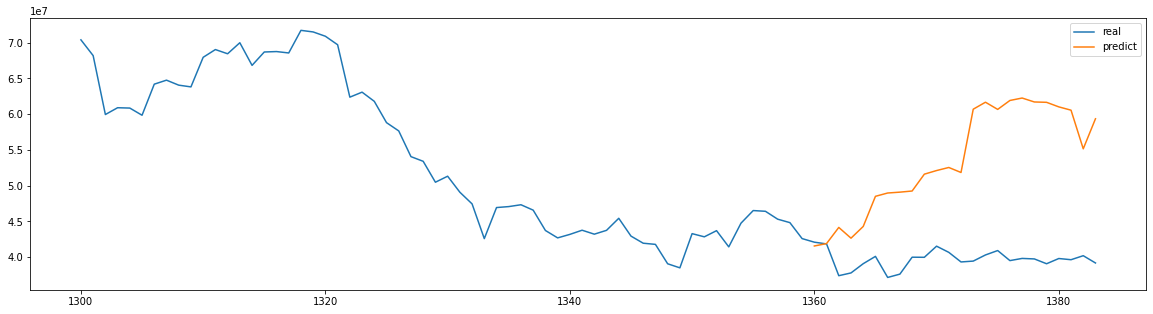

In [92]:
plt.figure(figsize=(20,5))
plt.plot(range(1300, 1384), real[1300:], label='real')
plt.plot(range(1384-24, 1384), preds, label='predict')
plt.legend()
plt.show()

In [94]:
def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPEval(preds, real[1360:])

35.11766412004603

## Test2

In [96]:
test_dataset = Dataset_Pred(dataframe=data_te ,scale=True, size = (seq_len, label_len,pred_len))
test_data_loader = DataLoader(dataset,batch_size=1,shuffle=shuffle_flag,num_workers=num_workers,drop_last=drop_last)

C:\Users\82108\AppData\Local\Temp\ipykernel_5452\2418081455.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw["date"] = pd.to_datetime(df_raw["date"])


In [97]:
seq_x, seq_y, seq_x_mark, seq_y_mark = next(iter(test_data_loader))

In [98]:
print(batch_x.shape)
print(batch_y.shape)
print(batch_x_mark.shape)
print(batch_y_mark.shape)

torch.Size([1, 96, 1])
torch.Size([1, 72, 1])
torch.Size([1, 96, 4])
torch.Size([1, 72, 4])


In [121]:
# 한번의 batch를 실행하는 코드
def predict(batch_x, batch_y, batch_x_mark, batch_y_mark):
    scaler = dataset.scaler

    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float()
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)
    dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
    dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float().to(device)
    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    batch_y = batch_y[:,-pred_len-label_len:,0:]
    
    preds = outputs.squeeze(0).detach().cpu().numpy()
    true = batch_y.squeeze(0).detach().cpu().numpy()

    return scaler.inverse_transform(preds), scaler.inverse_transform(true)

In [122]:
model.eval()

batch_x,batch_y,batch_x_mark,batch_y_mark = next(iter(test_data_loader))
pred, true = predict(batch_x, batch_y, batch_x_mark, batch_y_mark)


In [123]:
pred.shape

(24, 1)

In [124]:
true.shape

(72, 1)

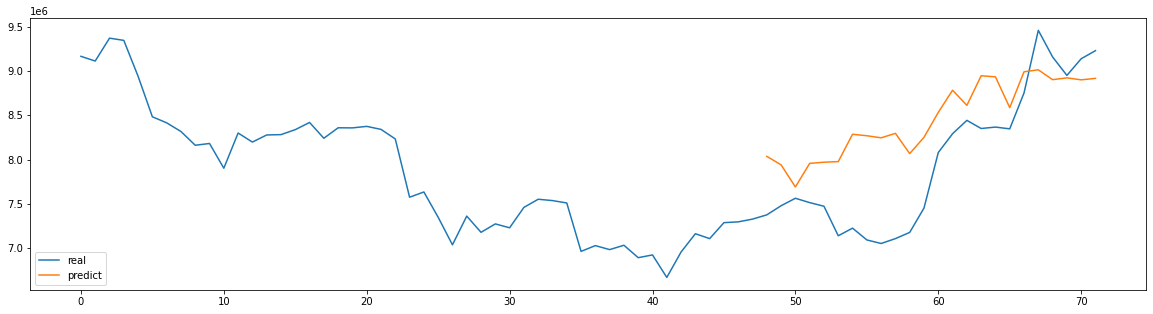

In [128]:
plt.figure(figsize=(20,5))
plt.plot(range(72),true, label="real")
plt.plot(range(72-24,72), pred, label="predict")
plt.legend()
plt.show()

In [132]:
MAPEval(pred, true[-24:])

7.324291342106175